In [2]:
import numpy as np
from skimage import io as skimage_io


class ImageParser:
    def __init__(self):
        pass

    @staticmethod
    def read_png(path):
        image = skimage_io.imread(path, as_gray=True)
        return np.add(image < 0.4, image < 0.8, dtype=int)

    @staticmethod
    def write_png(image, path):
        fib = [153, 1, 2]
        myo = [226, 168, 88]

        out_image = np.zeros((image.shape[0], image.shape[1], 3),
                             dtype=np.uint8)
        out_image[image == 1] = myo
        out_image[image == 2] = fib
        skimage_io.imsave(path, out_image)


100%|██████████| 40000/40000 [00:43<00:00, 929.45it/s] 


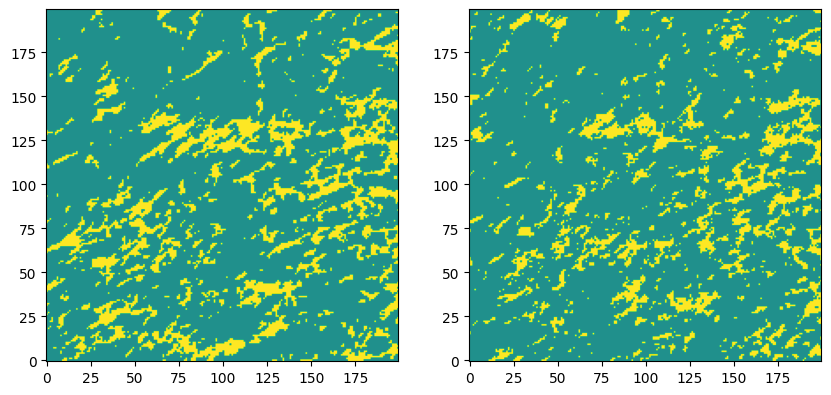

In [8]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

from joblib import Parallel, delayed

from bitis.tissue_models.direct_sampling.simulations import (
    TextureAdaptiveSimulation,
    TextureAdaptiveTrainingSimulation
)


def generate_image(training_image):
    simulation_image = np.zeros(training_image.shape, dtype=int)
    simulation = TextureAdaptiveTrainingSimulation(training_image,
                                                   simulation_image,
                                                   tr_shape=(100, 100),
                                                   max_size=20,
                                                   max_distance=30,
                                                   min_distance=1)
    simulation.run()
    return simulation_image


# path = Path('/Users/arstanbek/Projects/BiTis/data')
path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')
heart = 'E11444_LMNA'
slice_name = 'E11444_08_SC2'

y0 = 2300
dy0 = 400
x0 = 870
dx0 = 400

training_image = ImageParser.read_png(path.joinpath(heart, 'Images',
                                                    slice_name).with_suffix('.png'))
training_image = training_image[y0: y0+dy0, x0: x0+dx0]
# i = 3
# filename = f'or_tex_200_{i}.png'
# training_image = ImageParser.read_png(path.joinpath('training',
                                                    # filename))
training_image[training_image == 0] = 1

sim_image = np.zeros(training_image.shape, dtype=int)
out_mask = np.zeros_like(sim_image, dtype=bool)
out_mask[100:-100, 100:-100] = 1

# for x in [0, 90, 180]:
#     for y in [0, 90, 180]:
#         if x + 100 > training_image.shape[0]:
#             x_max = training_image.shape[0]
#             x = x_max - 100

#         if y + 100 > training_image.shape[1]:
#             y_max = training_image.shape[1]
#             y = y_max - 100

#         tr_image = training_image[x: x_max, y: y_max]
#         out_mask = np.zeros_like(sim_image, dtype=bool)
#         out_mask[x: x_max, y: y_max] = sim_image[x: x_max, y: y_max] == 0

#         simulation = TextureAdaptiveSimulation(tr_image,
#                                                sim_image,
#                                                max_size=20,
#                                                max_distance=30,
#                                                min_distance=1,
#                                                out_mask=out_mask)
#         sim_image = simulation.run()

simulation = TextureAdaptiveTrainingSimulation(training_image,
                                               sim_image,
                                               tr_shape=(100, 100),
                                               max_size=20, 
                                               max_distance=50,
                                               min_distance=1,
                                               out_mask=out_mask)
simulation.run()


# template_sizes = np.array(simulation.template_sizes)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(training_image[100:-100, 100:-100], origin='lower', vmin=0, vmax=2)
ax[1].imshow(sim_image[100:-100, 100:-100], origin='lower', vmin=0, vmax=2)
plt.show()

In [3]:

class AdaptiveTrainingDataBuilder:
    def __init__(self, training_image, max_shape=None):
        self.training_image = training_image
    
        if max_shape is None:
            max_shape = training_image.shape

        self.max_shape = np.array(max_shape)


    def build(self, i, j):
        ind = np.array([i, j])

        ind_min = (ind - self.max_shape // 2)
        ind_min[ind_min < 0] = 0
        ind_max = ind_min + self.max_shape
        
        tex_shape = np.array(self.training_image.shape)
        ind_max[ind_max > tex_shape] = tex_shape[ind_max > tex_shape]
        ind_min = ind_max - self.max_shape


        return self.training_image[ind_min[0]: ind_max[0],
                                   ind_min[1]: ind_max[1]]
    

training_image = np.zeros((1000, 1000), dtype=int)

%timeit AdaptiveTrainingDataBuilder(training_image, max_shape=50).build(78, 0)


4.61 µs ± 87.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Four pattern

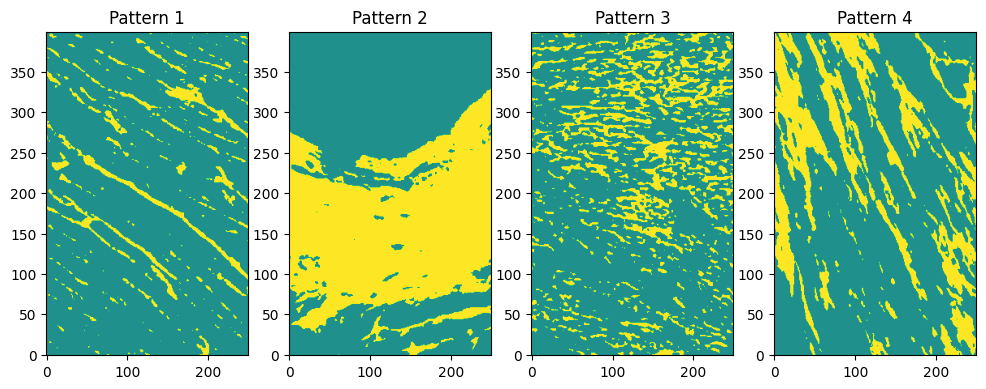

In [4]:
from pathlib import Path
from scipy import io
import matplotlib.pyplot as plt


path = Path('/Users/arstanbek/Projects/perlin-microfibrosis')

data = io.loadmat(path.joinpath('histo_patterns.mat'))

images = []

fig, axs = plt.subplots(ncols=4, figsize=(12, 5))
for i, im in enumerate(data['patterns'][0]):
    im = 1 + im[:, :]
    axs[i].imshow(im, origin='lower', vmin=0, vmax=2)
    axs[i].set_title(f'Pattern {i+1}')
    images.append(im)
    # axs[i].axis('off')
plt.show()

In [5]:
out = []


def generate_image(im):
    sim_image = np.zeros(im.shape, dtype=int)
    simulation = TextureAdaptiveTrainingSimulation(im,
                                                   sim_image,
                                                   tr_shape=(100, 100),
                                                   max_size=20,
                                                   max_distance=40,
                                                   min_distance=1)
    simulation.run()

    return sim_image


out = Parallel(n_jobs=4)(delayed(generate_image)(im) for im in images[:])

100%|██████████| 100000/100000 [01:27<00:00, 1145.23it/s]


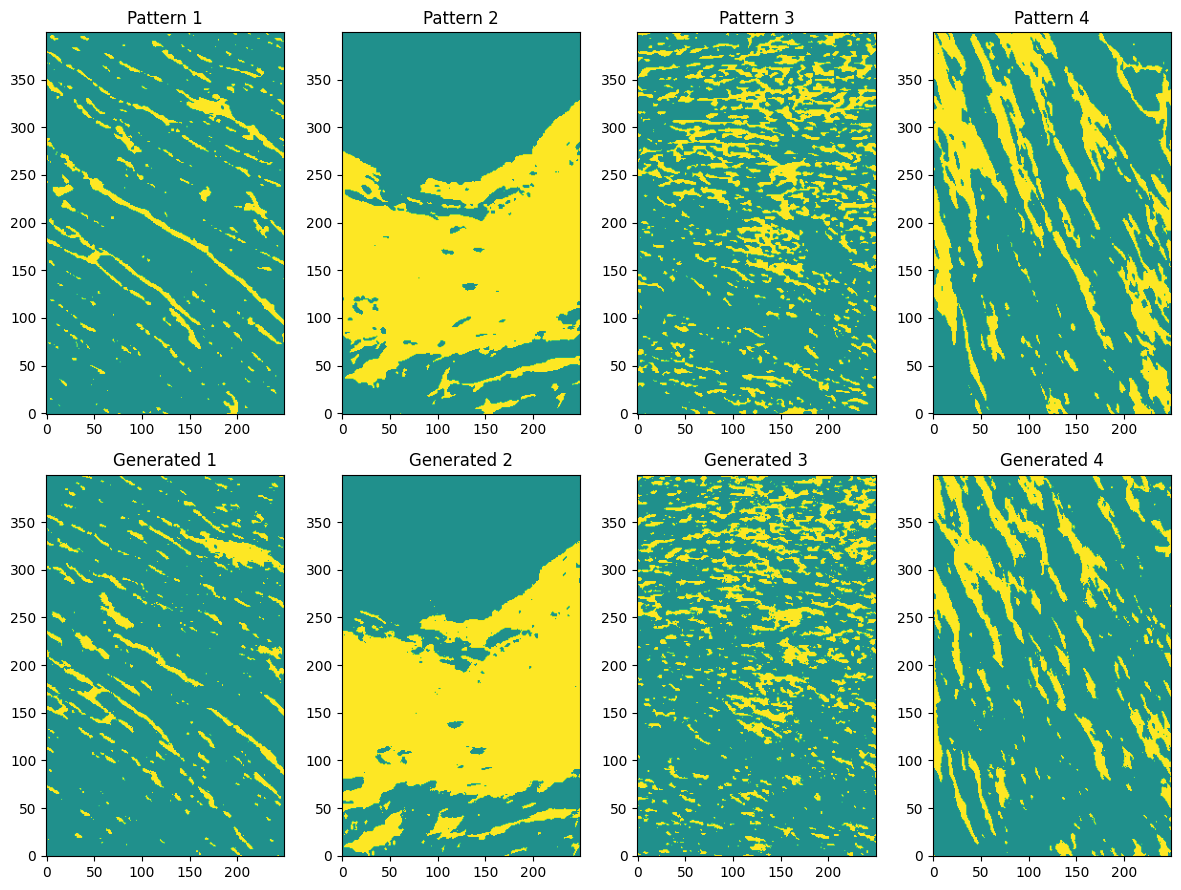

In [6]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(12, 9))
for i, (im_or, im_gen) in enumerate(zip(images, out)):
    axs[0, i].imshow(im_or, origin='lower', vmin=0, vmax=2)
    axs[0, i].set_title(f'Pattern {i+1}')

    axs[1, i].imshow(im_gen, origin='lower', vmin=0, vmax=2)
    axs[1, i].set_title(f'Generated {i+1}')
plt.tight_layout()
plt.show()

fig.savefig('four_patterns.png', dpi=300)

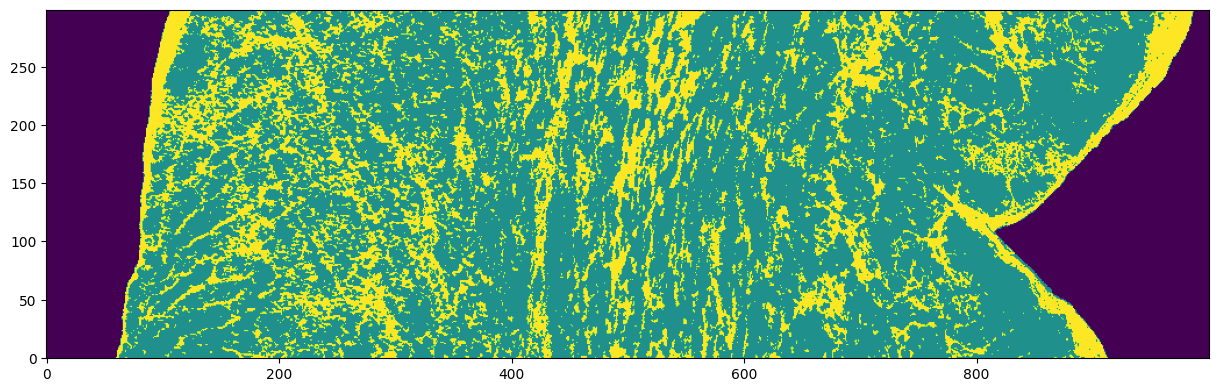

In [7]:
from skimage import morphology


path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data/')

filename = f'E11971_11_SC2_NABL.png'
training_image = ImageParser.read_png(path.joinpath('E11971_MYH7',
                                                    'Images',
                                                    filename))


mask = training_image > 0
mask = morphology.remove_small_holes(mask, area_threshold=10000)

training_image[(mask != 0) & (training_image == 0)] = 1

plt.figure(figsize=(15, 15))
plt.imshow(training_image[1500: 1800, :1000], origin='lower', vmin=0, vmax=2)
plt.show()

### Slice

In [8]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt


from bitis.tissue_models.direct_sampling.simulations import (
    TextureAdaptiveTrainingSimulation
)

# training_image[training_image == 0] = 1
# training_image = training_image[1500: 1800, :1000]

out_mask = training_image > 0

sim_image = np.zeros(training_image.shape, dtype=int)
simulation = TextureAdaptiveTrainingSimulation(training_image,
                                               sim_image,
                                               tr_shape=(100, 100),
                                               max_size=20,
                                               max_distance=30,
                                               min_distance=1,
                                               out_mask=out_mask)
simulation.run()

template_sizes = np.array(simulation.template_sizes)

 44%|████▍     | 2923295/6640603 [26:00<40:26, 1532.20it/s]

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(training_image, origin='lower', vmin=0, vmax=2)
ax[1].imshow(sim_image, origin='lower', vmin=0, vmax=2)
plt.show()

In [ ]:
fig.savefig('myh7.png', dpi=300)